# <center>VOTING CLASSIFIER</center>

***
## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES<br>
> B. COLLECTING DATA<br>
> C. TRANSLATION WITH HELSINKI-NLP MODEL<br>
> D. SPLIT BETWEEN TRAINING SET AND TEST SET<br>
> E. DATA PREPARATION WITH PREPROCESSING<br>

## <font color = blue>II. VOTING CLASSIFIER MODEL</font>
> A. CREATION OF RANDOM FOREST MODEL<br>
> B. CONFUSION MATRIX<br>
> C. CLASSIFICATION REPORT<br>
> D. WRONG PREDICTIONS<br>
### <font color = blue>III. OVERSAMPLING</font>
> A. RESAMPLING WITH RAMDOMOVERSAMPLER<br>
> B. CONFUSION MATRIX<br>
> C. CLASSIFICATION REPORT<br>
> D. WRONG PREDICTIONS<br>

## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES<br>

In [12]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm
from sklearn.ensemble import VotingClassifier

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as metrics
import itertools

> B. COLLECTING DATA<br>

In [13]:
df = pd.read_csv('../data/data.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,filename,url,description,type,filepath,scraped,old_filename,old_filepath,...,text_ocr,words_count,text_en,text_fr,text_fr_norm,text_en_norm,target_en,target_fr,target,target_min
0,0,0,img_0000000.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000000.jpg,1,img_0000000.jpg,./facture/img_0000000.jpg,...,FACTURE LOGO Joanna Binet 48 Coubertin 31400 ...,98,Invoice Logo Joanna Binet Coubertin Paris Invo...,Facture Logo Joanna Binet Coubertin Paris F...,facture logo joanna binet coubertin paris fact...,invoice logo joanna binet coubertin paris invo...,invoice,facture,invoice,invoice
1,1,1,img_0000001.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000001.jpg,1,img_0000001.jpg,./facture/img_0000001.jpg,...,Joanna Binet 48 Coubertin 31400 Paris FACTURE...,97,Joanna Binet Coubertin Paris Invoice Invoice i...,Joanna Binet Coubertin Paris Facture Factur...,joanna binet coubertin paris facture facturé c...,joanna binet coubertin paris invoice invoice c...,invoice,facture,invoice,invoice
2,2,2,img_0000002.jpg,https://www.coover.fr/wp-content/uploads/2021/...,Facture proforma : modèle à télécharger gratui...,facture,./final/img_0000002.jpg,1,img_0000002.jpg,./facture/img_0000002.jpg,...,FACTURE Mon entreprise : Nom de la société Ad...,45,Invoice My company : Company name Mail address...,Facture Mon entreprise : Nom de la société Ad...,facture entreprise société adresse postale adr...,invoice company company name mail address tele...,invoice,facture,invoice,invoice
3,3,3,img_0000003.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000003.jpg,1,img_0000003.jpg,./facture/img_0000003.jpg,...,Joanna Binet 48 Coubertin 31400 Paris FACTURE...,99,Joanna Binet Coubertin Paris Bill To Cinderell...,Joanna Binet Coubertin Paris Facture À Cend...,joanna binet coubertin paris facture cendrillo...,joanna binet coubertin paris bill cinderella a...,invoice,facture,invoice,invoice
4,4,4,img_0000004.jpg,https://files.intum.com/v/vosfactures/files/31...,Base de Connaissances - Vos Factures - Créer u...,facture,./final/img_0000004.jpg,1,img_0000004.jpg,./facture/img_0000004.jpg,...,Payer en ligne > FACTURE No SFIDELI F/05.2020...,157,Pay online Invoice No Sfideli F/ Creation date...,Payer en ligne Facture No Sfideli F/ Date de...,payer ligne facture sfideli date création date...,online invoice sfideli creation date validity ...,invoice,facture,invoice,invoice


In [14]:
#show the number of documents per type
df.type.value_counts()

paye                      239
carte postale             214
id_pieces                 138
passeport                 104
facture                    73
justif_domicile            40
presentation               40
handwritten                40
news_article               36
advertisement              33
budget                     33
invoice                    32
scientific_report          32
questionnaire              31
memo                       31
resume                     30
letter                     29
scientific_publication     28
email                      28
form                       27
specification              26
file_folder                24
Name: type, dtype: int64

In the following steps, we will only use the documents in french

In [15]:
# Replace current classes by new classes i.e by grouping certain classes together
def replace_target(df):
    new_classes =  { 'advertisement': 'other_types',
                    'form'        : 'other_types',
                   'handwritten' : 'other_types',
                   'letter' : 'other_types',
                    'memo': 'other_types',
                    'presentation': 'other_types',
                   'invoice' :'facture',
                   'new_article': 'scientific_doc',
                   'scientific_publication': 'scientific_doc',
                   'scientific_report': 'scientific_doc'}

    df = df.replace(new_classes)
    # Creating dictionary
    dico_type = {'facture': 0,
                 'id_pieces': 1,
                 'justif_domicile': 2,
                 'passeport': 3,
                 'paye': 4,
                 'carte postale': 5,
                 'other_types': 6,
                 'scientific_doc': 7,
                 'resume': 8,
                 'specification': 9,
                 'budget': 10,
                 'file_folder': 11,
                 'email': 12,
                 'questionnaire': 13}

    # Creating revert dictionary
    dico_type_inv = {v: k for k, v in dico_type.items()}

    # Convert types according to the dictionary
    df['type_num'] = df.type.replace(dico_type)
    df.head()

In [16]:
df=df.dropna(subset=['text_en_norm'])

X = df['text_en_norm']# text is the feature
y = df['target_min']# type is the target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=1234)# Assign 20% of the dataset records to the test set

In [17]:
tfid = TfidfVectorizer()# Initialization of  a vectorizer with TfidfVectorizer method

X_train = tfid.fit_transform(X_train)# Fit then transform X_train
X_test = tfid.transform(X_test)# Transform X_test

pd.DataFrame(X_train).head()#Get the 5 first rows of X_train

,0
0,"(0, 19847)\t0.4645488034897779\n (0, 2979)\..."
1,"(0, 8331)\t0.1577574558588645\n (0, 14575)\..."
2,"(0, 7948)\t0.0539891712592131\n (0, 567)\t0..."
3,"(0, 7639)\t0.3806806997211806\n (0, 16175)\..."
4,"(0, 7036)\t0.055910235604074446\n (0, 2080)..."


We decided to add a VotingClassifierin order to combine conceptually different machine learning classifiers and use a majority vote to predict the class labels. 
As we have almost a set of equally well performing models, we would like to balance out their individual weaknesses.

In [18]:
svc = svm.SVC()

model_1 = GradientBoostingClassifier()

model_2 = ensemble.RandomForestClassifier( n_jobs =-1) # Creation of clf classifier after Random oversampling
model_3 = linear_model.LogisticRegression(C=1.0)# Creation of clf classifier# Creation of clf classifier after Random oversampling
model_4 = svm.SVC(C=10,gamma=0.2, kernel= 'rbf')

model_5= VotingClassifier([('GB',model_1),
                           ('RF', model_2),
                           ('LR', model_3),
                           ('svm', model_4)],
                           voting = 'hard')

In [19]:
for model in (model_1,model_2, model_3,model_4, model_5):
  model.fit(X_train, y_train)
  y_pred = model.__class__.__name__,model.predict(X_test)# Prediction on the test set 
  print(model.__class__.__name__,model.score(X_test,y_test))

GradientBoostingClassifier 0.7298578199052133
RandomForestClassifier 0.7630331753554502
LogisticRegression 0.7251184834123223
SVC 0.7630331753554502
VotingClassifier 0.7772511848341233


In [20]:
y_pred=model_5.predict(X_test)# Prediction on the test set 

> B. CONFUSION MATRIX<br>

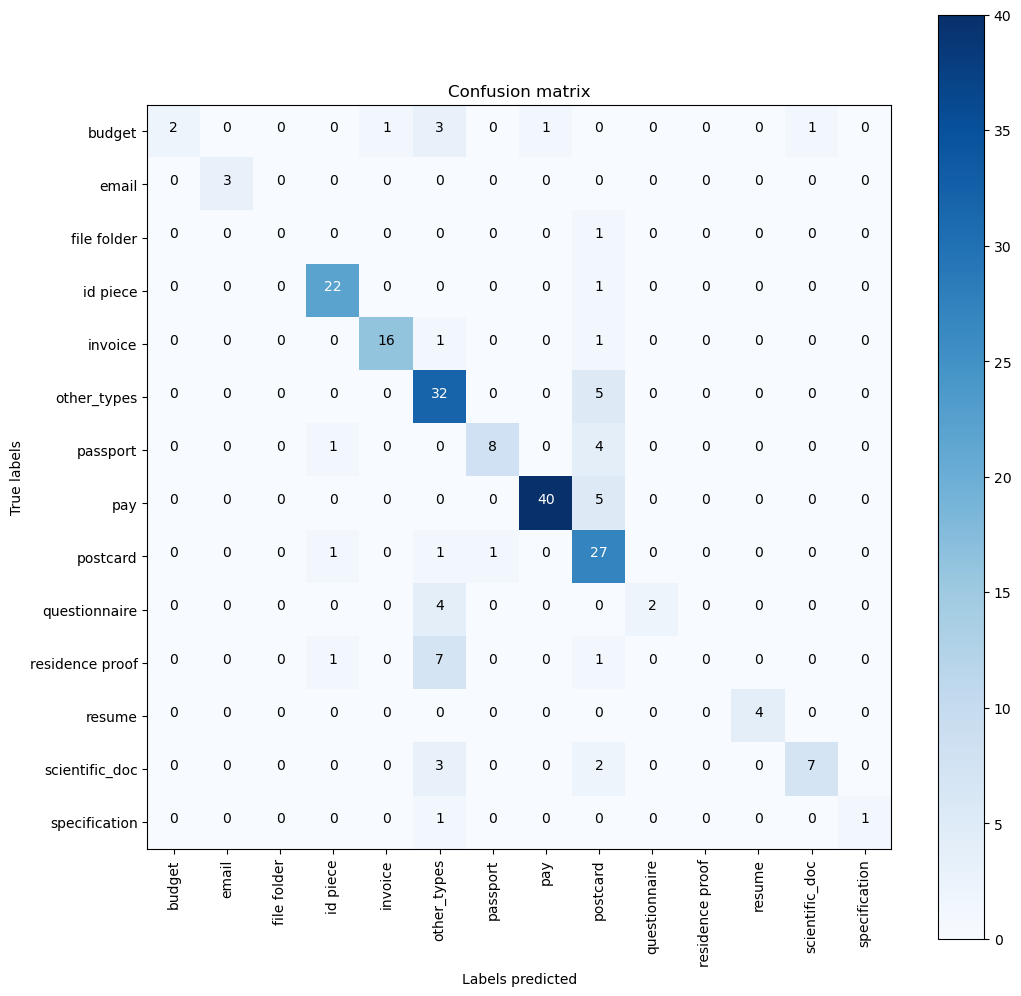

In [30]:
def confusion_matrix(y_test, y_pred,classes=[]):
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    if (len(classes)==0):
        extract_classes = pd.DataFrame(data = y_test.unique(), columns = ['classe']).sort_values(by = 'classe', ascending = True)
        classes = extract_classes.classe #range(0,21)

    plt.figure(figsize = (12, 12))

    plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment = "center",
                 color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('True labels')
    plt.xlabel('Labels predicted')
    plt.show()
confusion_matrix(y_test,y_pred)

> C.CLASSIFICATION REPORT<br>

In [22]:
# Class predictions per type of document (passport, questionnaire, etc...)
def global_classification_report(y_test, y_pred,classifier="None",category="None"):    
    append = False
    if(os.path.exists('../data/classification_report.csv')):
        df = pd.read_csv('../data/classification_report.csv')
        append = True
  
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose().reset_index() 
    df_report['classifier'] = classifier
    df_report['category'] = category    
    
    if (append):
        df = df.drop(df[(df['classifier']==classifier) & (df['category']==category)].index)
        df = pd.concat([df, df_report])
    else:
        df = df_report
        
    df.to_csv('../data/classification_report.csv',index=False)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

         budget       1.00      0.25      0.40         8
          email       1.00      1.00      1.00         3
    file folder       0.00      0.00      0.00         1
       id piece       0.88      0.96      0.92        23
        invoice       0.94      0.89      0.91        18
    other_types       0.62      0.86      0.72        37
       passport       0.89      0.62      0.73        13
            pay       0.98      0.89      0.93        45
       postcard       0.57      0.90      0.70        30
  questionnaire       1.00      0.33      0.50         6
residence proof       0.00      0.00      0.00         9
         resume       1.00      1.00      1.00         4
 scientific_doc       0.88      0.58      0.70        12
  specification       1.00      0.50      0.67         2

       accuracy                           0.78       211
      macro avg       0.77      0.63      0.66       211
   weighted avg       0.79   

/Users/rymbenhassine/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rymbenhassine/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rymbenhassine/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu